<a href="https://colab.research.google.com/github/sadrabr/LLM_projects/blob/main/chatbot_FlightAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
import os
# from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import json

In [ ]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
# Start Ollama server

import subprocess

# Start the command in a background process
process = subprocess.Popen(["ollama", "serve"])

# The kernel can continue execution while the process runs in the background
print("The 'ollama serve' process is running in the background.")

The 'ollama serve' process is running in the background.


In [ ]:
# install the Ollama python API package

!pip install ollama

In [ ]:
!ollama pull llama3.2

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest 
pulling dde5aa3fc5ff:   1% ▕▏  11 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:   2% ▕▏  47 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:   5% ▕▏ 106 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:   6% ▕▏ 114 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:   8% ▕▏ 157 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:  10% ▕▏ 205 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:  11% ▕▏ 222 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:  13% ▕▏ 256 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:  15% ▕▏ 309 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:  16% ▕▏ 332 MB/2.0 GB                  pulling manifest 
pu

In [ ]:
openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')
MODEL = 'llama3.2'

In [ ]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [ ]:
# making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499","iran":"$599"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")
get_ticket_price("Iran")

Tool get_ticket_price called for Iran


'$599'

In [ ]:
# There's a particular dictionary structure

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [ ]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

In [ ]:
# write function that handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [ ]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)

    return response.choices[0].message.content

In [ ]:
# gr.ChatInterface(fn=chat, type="messages").launch()

In [ ]:
import base64
from io import BytesIO
from PIL import Image
import torch
from diffusers import StableDiffusionXLPipeline

# تنظیم مدل SDXL (متنباز)
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = StableDiffusionXLPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
)
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

def artist(city):
    prompt = f"""
    A vibrant pop-art style image representing a vacation in {city},
    showing iconic tourist spots, cultural elements, and unique landmarks,
    ultra-detailed, 4k resolution, dynamic composition
    """

    # تولید تصویر با SDXL
    image = pipe(
        prompt,
        width=1024,
        height=1024,
        num_inference_steps=50,
        guidance_scale=8.0  # کنترل خلاقیت (مقادیر بالاتر = تطابق بیشتر با متن)
    ).images[0]

    # تبدیل به base64 (اختیاری)
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    image_base64 = base64.b64encode(buffered.getvalue()).decode()
    return Image.open(BytesIO(base64.b64decode(image_base64)))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.fp16.saf(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

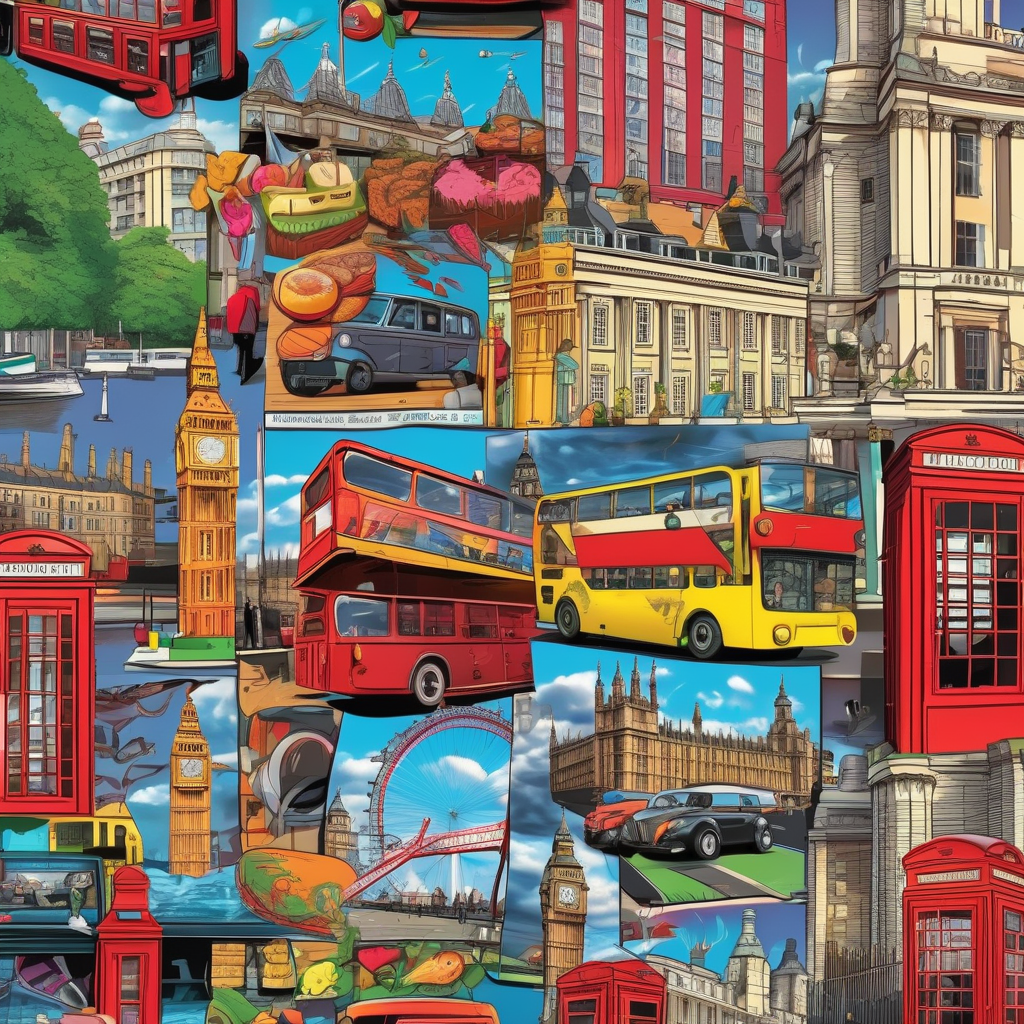

In [ ]:
tehran_image = artist("London")
display(tehran_image)

In [ ]:
!pip install pyttsx3

In [ ]:
!pip install gtts

In [ ]:
from gtts import gTTS
from IPython.display import Audio, display
from io import BytesIO
import base64

def talker(message):
    # تولید صوت با gTTS
    tts = gTTS(text=message, lang='en', slow=False)

    # ذخیره صوت در بافر باینری (اختیاری)
    audio_buffer = BytesIO()
    tts.write_to_fp(audio_buffer)
    audio_buffer.seek(0)

    # پخش خودکار صوت
    display(Audio(audio_buffer.read(), autoplay=True))

In [ ]:
talker("""Hi there,
what's up""")

In [ ]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)

    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)

    return history, image

In [ ]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://892c8b4d333561f87a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
